# COMP41680 - Assignment 1
##### Adam Judge - 16343971

## Task 1: Identify one or more suitable web APIs
###### Api Chosen:
A single API chosen for this assignment was the COVID-19 API - https://covid19api.com/


In [275]:
import os
import numpy as np
import urllib.request
import csv
import json
import pandas as pd 
import requests
import time
%matplotlib inline 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

# Task 1: Collect data from chosen API
###### Collect Data:
The following functions are used in the creation of files, Collection of data

In [2]:
def Json2file(Folder, FileName, Data):
    print(f"Writing JSON data to {Folder}/{FileName}")
    with open(Folder+"/"+FileName, "w") as File:
        json.dump(Data, File)
    File.close()

def makeDir(Folder):
    if not os.path.exists(Folder):
        os.mkdir(Folder)
    else:
        print(f"Folder {Folder} already exists!")


#### Raw COVID-19 data will be extracted for all countries in the European Union and written to .json files

In [3]:
countries = ["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland",
             "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg",
             "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"]
# 100ks of person per country based on National Estimates
pop100ks =    {"Austria": 8857960/100000,
               "Belgium": 11449656/100000,
               "Bulgaria": 7000039/100000,
               "Croatia": 4105493/100000,
               "Cyprus": 864200/100000,
               "Czechia": 10627794/100000,
               "Denmark": 5837213/100000,
               "Estonia": 1328976/100000,
               "Finland": 5522015/100000,
               "France": 67076000/100000,
               "Germany": 83122889/100000,
               "Greece": 10768193/100000,
               "Hungary": 9771000/100000,
               "Ireland": 4921500/100000,
               "Italy": 60390560/100000,
               "Latvia": 1921300/100000,
               "Lithuania": 2794090/100000,
               "Luxembourg": 626108/100000,
               "Malta": 514564/100000,
               "Netherlands": 17417600/100000,
               "Poland": 38433600/100000,
               "Portugal": 10276617/100000,
               "Romania": 19523621/100000,
               "Slovakia": 5445087/100000,
               "Slovenia": 2070050/100000, 
               "Spain": 46733038/100000,
               "Sweden": 10319601/100000}


In [9]:
FileNames=[]
ErrCnt=0
makeDir("Raw_Data")
RawFolder="./Raw_Data"
for i, c in enumerate(countries):
    URL=f"http://api.covid19api.com/total/dayone/country/{c}"
    response=requests.get(URL)
    if response.status_code == 200:
        print(f"Successfully obtained data for {c}")
        Json2file("./Raw_Data",f"{c}_rawdata.json", response.json())
        FileNames.append(f"{c}_rawdata.json")
    else:
        print(f"Error for country {c}, {response.status_code}")
        ErrCnt+=1
    # Delay so as to not request too much in short period of time
    time.sleep(1)
print(f"Number of errors: {ErrCnt}")

Folder Raw_Data already exists!
Successfully obtained data for Austria
Writing JSON data to ./Raw_Data/Austria_rawdata.json
Successfully obtained data for Belgium
Writing JSON data to ./Raw_Data/Belgium_rawdata.json
Successfully obtained data for Bulgaria
Writing JSON data to ./Raw_Data/Bulgaria_rawdata.json
Successfully obtained data for Croatia
Writing JSON data to ./Raw_Data/Croatia_rawdata.json
Successfully obtained data for Cyprus
Writing JSON data to ./Raw_Data/Cyprus_rawdata.json
Successfully obtained data for Czechia
Writing JSON data to ./Raw_Data/Czechia_rawdata.json
Successfully obtained data for Denmark
Writing JSON data to ./Raw_Data/Denmark_rawdata.json
Successfully obtained data for Estonia
Writing JSON data to ./Raw_Data/Estonia_rawdata.json
Successfully obtained data for Finland
Writing JSON data to ./Raw_Data/Finland_rawdata.json
Successfully obtained data for France
Writing JSON data to ./Raw_Data/France_rawdata.json
Successfully obtained data for Germany
Writing JSO

## Data Preparation and Modification Functions
##### Parsing Raw Data:
The raw data for each country starts from the first known covid case reported in said country, and the following columns of data are contained in the raw data in order:
* Country
* CountryCode
* Province
* City
* CityCode
* Lat
* Lon
* Confirmed
* Deaths
* Recovered
* Active
* Date

It can be noted that the active and recovered numbers are poor as these numbers are simply not tracked to any reasonable degree of accuracy in the majority of countries.
The Lat and Lon, or latitude and longitude may be discarded, as well as the CountryCode, Province, City, CityCode, Recovered, and Active. These are not of interest in the comparison between european countries.

Additional columns are desired for this such as New Cases, New Deaths, as well as data per 100k of population. These will allow for the comparison between countries with varied population sizes, such as Malta and Germany. These columns may be inferred from the cumulative deaths and confirmed columns as well as the date.

Any missing data such as missing dates will be added to the dataset, with new cases and new deaths being taken as 0 for these periods. The cumulative values will take the previous dates values.

In [348]:
# This function extracts the daily new cases from the total cumulative cases
def getDailyCasesDeaths(df):
    TotalCases=df["Confirmed"].tolist()
    TotalDeaths=df["Deaths"].tolist()
    DailyCases=[]
    DailyDeaths=[]
    negCaseOcc=0
    negDeathOcc=0
    # Iterate through the total confirmed cases
    for i, TC in enumerate(TotalCases):
        #First is the first case(s)
        if i == 0:
            DailyCases.append(TC)
            continue
        
        # Difference between current day and previous days cases    
        newCases=TC-TotalCases[i-1]
        if newCases<0:  
            negCaseOcc+=1
            
        DailyCases.append(newCases)

    for i, TD in enumerate(TotalDeaths):
        #First is the first death(s)
        if i == 0:
            DailyDeaths.append(TD)
            continue
        
        # Difference between current day and previous days deaths    
        newDeaths=TD-TotalDeaths[i-1]
        if newDeaths<0:  
            negDeathOcc+=1
            
        DailyDeaths.append(newDeaths)
        
    return DailyCases, DailyDeaths, negCaseOcc, negDeathOcc

# Returns Deaths, Confirmed, Daily Deaths, Daily Confirmed per 100k of population
def perCapita(df, num):
    confirmedPer=df["Confirmed"]/num
    deathsPer=df["Deaths"]/num
    dailyCasesPer=df["New Cases"]/num
    dailyDeathsPer=df["New Deaths"]/num
    return confirmedPer, deathsPer, dailyCasesPer, dailyDeathsPer

# Function to pad data for missing dates from 2020-01-01 to present
def padDates(df):
    # First date will be 2020-01-01
    nextDate=date.fromisoformat("2020-01-01")
    missingCnt=0
    addedCnt=0
    i=0
    # Check all rows based on Date
    while nextDate != datetime.today().date():
        # If the date is present do nothing
        if(nextDate in df["Date"].values):
            pass
        # If date is missing
        else:
            # If first row, cases deaths and new cases all should be zero
            if i==0:
                row2add=[nextDate, df["Country"][i], 0, 0, 0, 0, 0, 0, 0, 0]
            # If not first row, new cases should be 0, confirmed cases and deaths should be same as prior row
            else:    
                row2add=[nextDate, df["Country"][i], df["Confirmed"][i-1], df["Confirmed per 100k"][i-1], 0, 0, df["Deaths"][i-1],df["Deaths per 100k"][i-1], 0, 0]
                # Missing date found in middle of data and not at beginning
                if df["Confirmed"][i-1] != 0:
                    missingCnt+=1
                    
            # Make a dataframe with new row
            new_df=pd.DataFrame([row2add], columns=df.columns.values)
            #print(f"Adding \"{row2add}\"")
            # Concatenate new row to correct position in dataframe
            df=pd.concat([df[:i], new_df, df[i:]], ignore_index=True)
            addedCnt+=1
            
        i+=1
        nextDate+=timedelta(days=1)
    
    return df, missingCnt, addedCnt

# Want Date First
def reorderCols(df, Cols):
    dftest=df[Cols]
    return dftest

# Function to remove hr/min/sec/TimeZone from Date entries
def removeTime(df):
    dates=[]
    for d in df["Date"]:
        try:
            dates.append(d.date())
        except:
            dates.append(d)
        
    return dates

Processing Data

In [349]:
Columns2Drop=["CountryCode", "Province", "City", "CityCode", "Lat", "Lon", "Recovered", "Active"]
Cols=["Date", "Country", "Confirmed", "Confirmed per 100k", "New Cases", "New Cases per 100k", "Deaths", "Deaths per 100k", "New Deaths", "New Deaths per 100k"]
negCaseOcc=0
negDeathOcc=0
missingMid=0
missingTot=0
ProcessedDataFolder="./Processed"
FileNamePro=[]
makeDir(ProcessedDataFolder)

# Process data, remove unnecessary columns and append any missing data as appropriate
for country, filename in zip(countries, FileNames):
    # Read raw data
    df=pd.read_json(RawFolder+"/"+filename, orient="records")
    # Drop unnecessary columns
    df=df.drop(Columns2Drop, axis=1)
    # Add new cases and new deaths columns
    df["New Cases"], df["New Deaths"], nc, nd = getDailyCasesDeaths(df)
    #    return confirmedPer, deathsPer, dailyCasesPer, dailyDeathsPer
    df["Confirmed per 100k"], df["Deaths per 100k"], df["New Cases per 100k"], df["New Deaths per 100k"] = perCapita(df,pop100ks[country])

    # Reorder columns in preferred order
    df=reorderCols(df, Cols)
    # Add missing Dates
    df, missingCnt, addedCnt=padDates(df)
    # No interest in hours/mins/secs/timezone
    df["Date"] = removeTime(df)
    df=df.round(decimals=2)
    missingMid+=missingCnt
    missingTot+=addedCnt
    negCaseOcc+=nc
    negDeathOcc+=nd
    fileNamePro=f"{country}_processed.csv"
    FileNamePro.append(fileNamePro)
    # Write processed data to csv file
    #Json2file(ProcessedDataFolder, fileNamePro, df.to_json(date_format = "iso",orient="records"))
    df.to_csv(ProcessedDataFolder + "/" + fileNamePro)
    print("Written for " + country)
    dfnew=df

print(f"Number of missing date entries found after first case: {missingMid}")
print(f"Number of missing date entries found in total: \t{missingTot}")
print(f"Number of days found in total with a drop in cumulative case numbers: {negCaseOcc}")
print(f"Number of days found in total with a drop in cumulative death numbers: {negDeathOcc}")

Folder ./Processed already exists!
Written for Austria
Written for Belgium
Written for Bulgaria
Written for Croatia
Written for Cyprus
Written for Czechia
Written for Denmark
Written for Estonia
Written for Finland
Written for France
Written for Germany
Written for Greece
Written for Hungary
Written for Ireland
Written for Italy
Written for Latvia
Written for Lithuania
Written for Luxembourg
Written for Malta
Written for Netherlands
Written for Poland
Written for Portugal
Written for Romania
Written for Slovakia
Written for Slovenia
Written for Spain
Written for Sweden
Number of missing date entries found after first case: 0
Number of missing date entries found in total: 	1411
Number of days found in total with a drop in cumulative case numbers: 20
Number of days found in total with a drop in cumulative death numbers: 52


In [340]:
datetime.strptime("01-01-2020", "%M-%d-%Y").date()+timedelta(days=436)
#datetime.today().date()

datetime.date(2021, 3, 12)

In [375]:
def plotCovidDF(df):
    df["Date"]=pd.to_datetime(df["Date"])
    plt.figure(figsize=(16,12));
    tickRange=np.arange(df["Date"].iloc[0], df["Date"].iloc[-1], timedelta(days=60));
    
    # First Subplot
    plt.subplot(2, 2, 1)
    # Plot
    plt.plot_date(df["Date"] ,df["Confirmed per 100k"], linestyle="solid", marker=None)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("Cases per 100k")
    plt.title(f"{df['Country'].iloc[0]}: Cumulative Cases per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim([df["Date"].iloc[0], df["Date"].iloc[-1]])
    plt.ylim([0, max(df["Confirmed per 100k"])])


    # Second Subplot
    plt.subplot(2,2,2)
    # Plot
    plt.plot_date(df["Date"],df["Deaths per 100k"],'k')
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("Deaths per 100k")
    plt.title(f"{df['Country'].iloc[0]}: Cumulative Deaths per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim([df["Date"].iloc[0], df["Date"].iloc[-1]])
    plt.ylim([0, max(df["Deaths per 100k"])])


    # Third Subplot
    plt.subplot(2, 2, 3)
    # Plot
    plt.plot(df["Date"],df["New Cases per 100k"].rolling(7).mean(), linewidth="2.5", linestyle="solid", marker=None)
    plt.bar(df["Date"], df["New Cases per 100k"], 1, color='r')
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("New Cases per 100k")
    plt.title(f"{df['Country'].iloc[0]}: Daily New Cases per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim([df["Date"].iloc[0], df["Date"].iloc[-1]])
    plt.ylim([0, max(df["New Cases per 100k"])*1.1])

    # Fourth Subplot
    plt.subplot(2, 2, 4)
    # Plot
    plt.bar(df["Date"], df["New Deaths per 100k"], 1, color='r')
    plt.plot(df["Date"], df["New Deaths per 100k"].rolling(7).mean(), linewidth="2.5", linestyle="solid", marker=None)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("New Deaths per 100k")
    plt.title(f"{df['Country'].iloc[0]}: Daily New Deaths per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim([df["Date"].iloc[0], df["Date"].iloc[-1]])
    plt.ylim([0, max(df["New Deaths per 100k"])*1.1])

    plt.tight_layout()

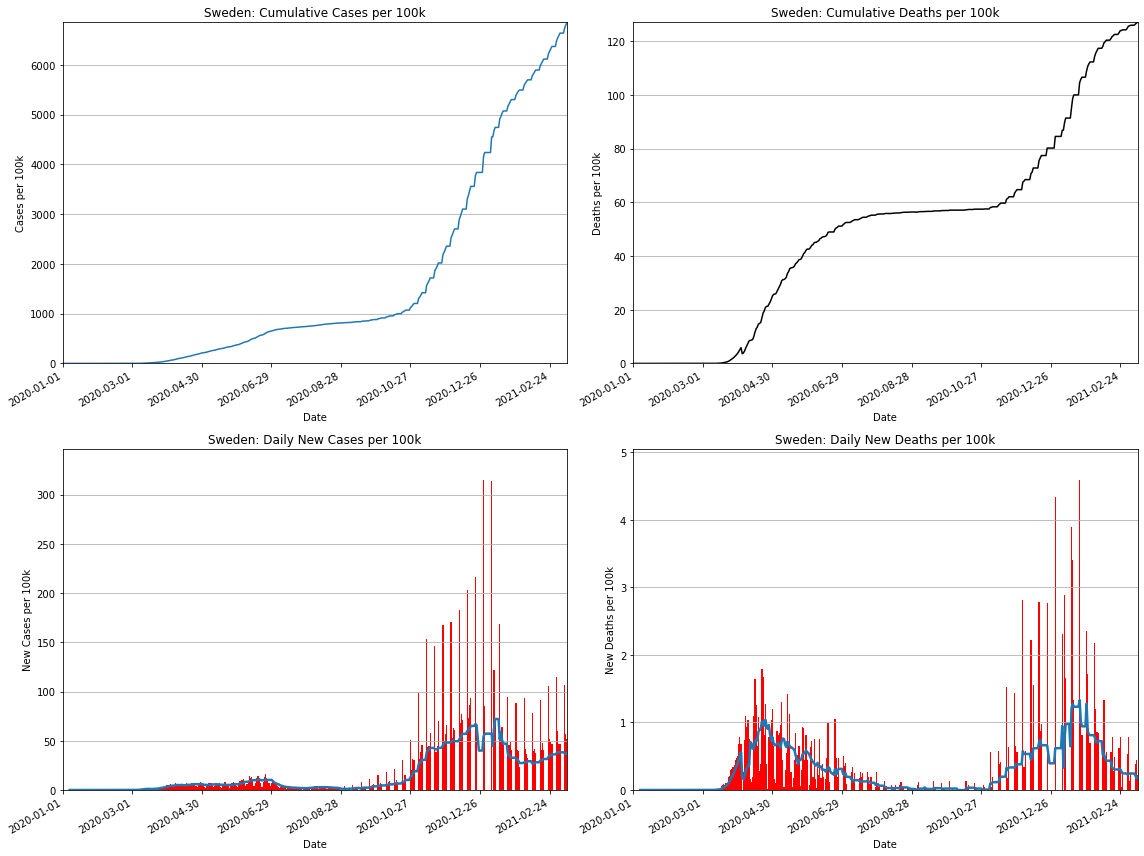

In [357]:
plotCovidDF(dfnew)

In [224]:
dfnew.to_csv("out.csv")
#dftest=pd.read_json(ProcessedDataFolder+"/"+"ireland_processed.json")
ProcessedDataFolder + "/" + fileNamePro

'./Processed/Sweden_processed.csv'

<ipython-input-375-9de921c12d27>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,12));
<ipython-input-375-9de921c12d27>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,12));
<ipython-input-375-9de921c12d27>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(1

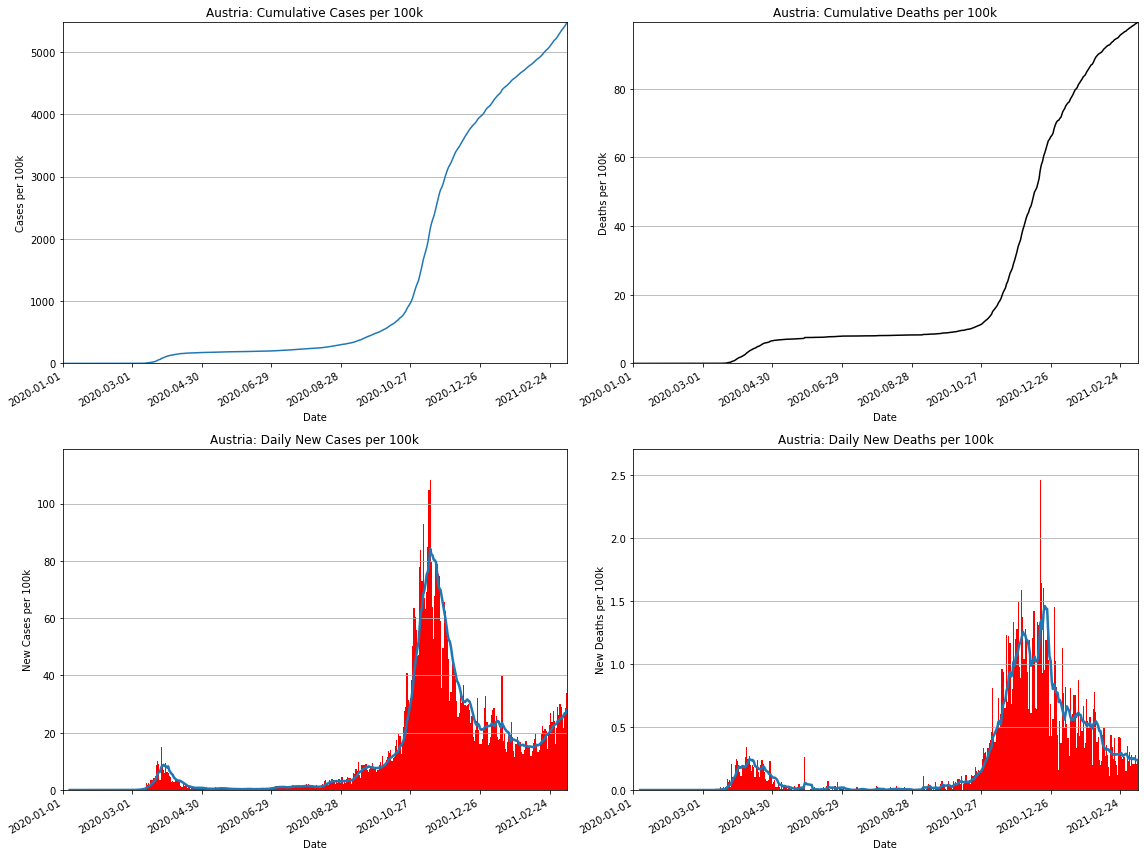

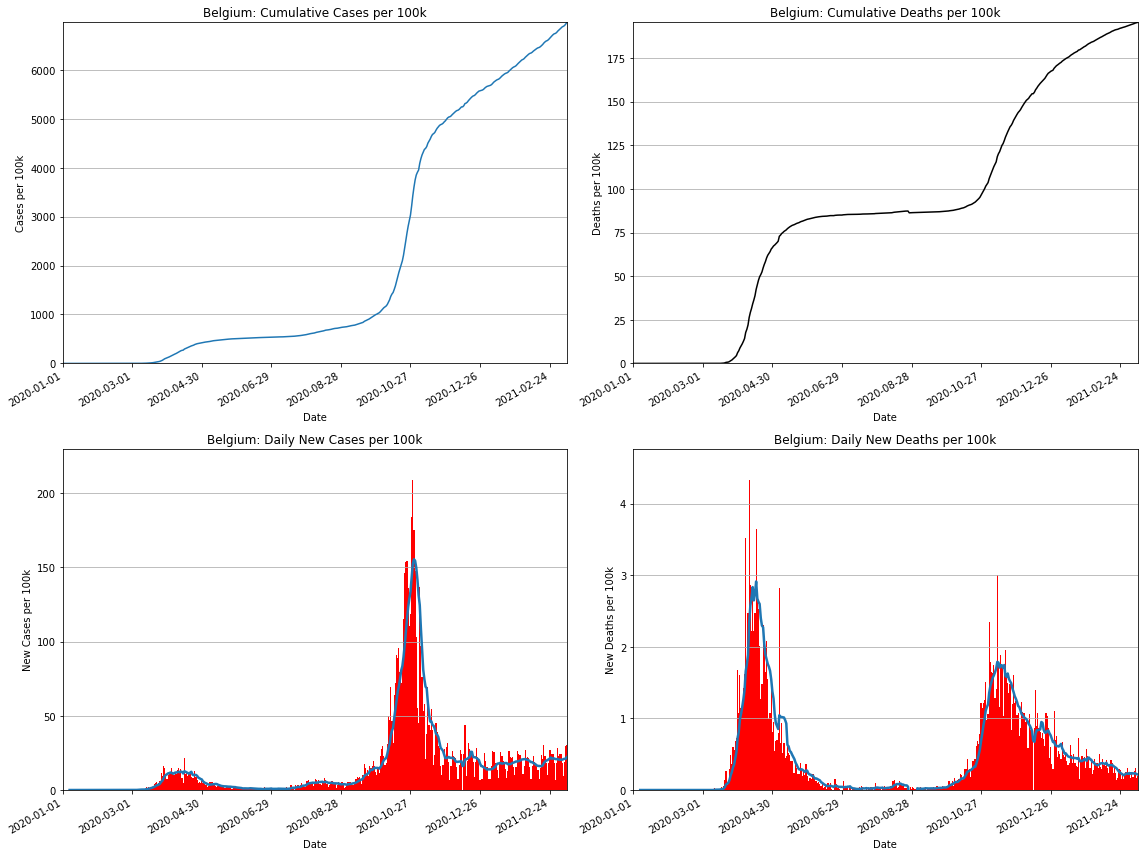

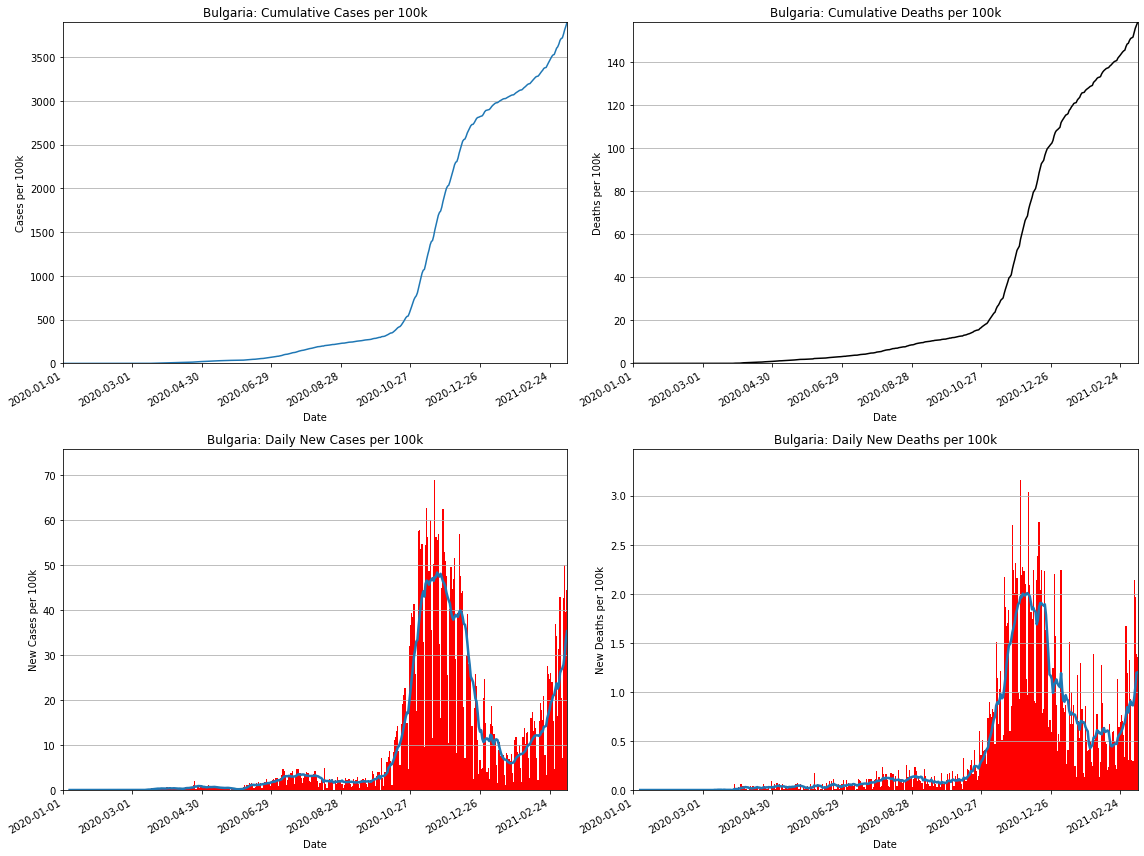

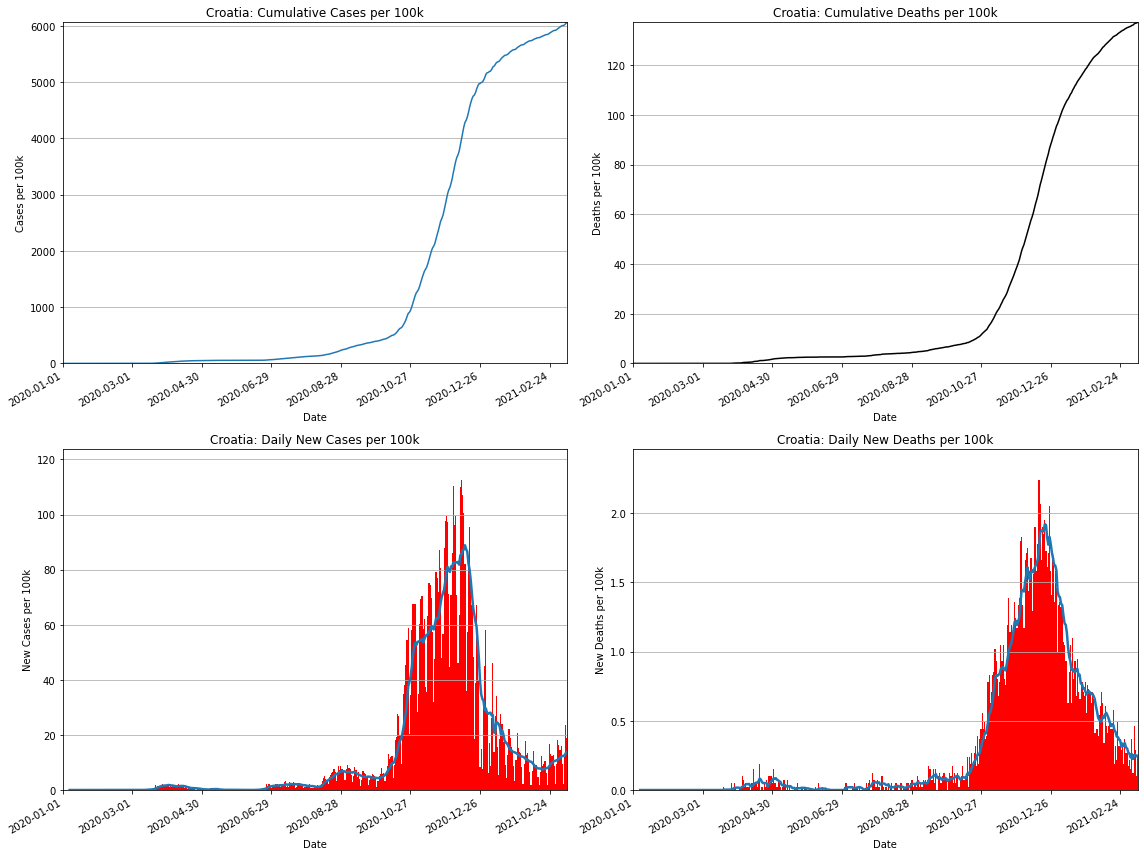

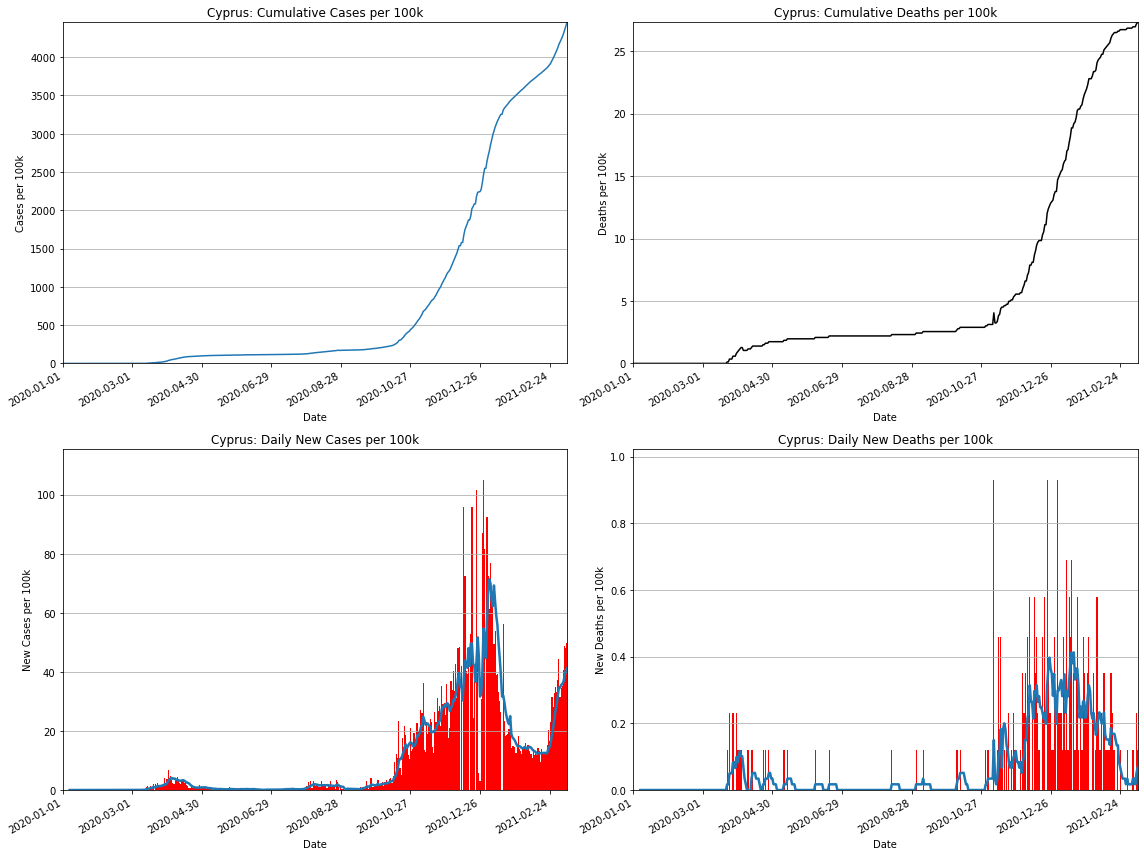

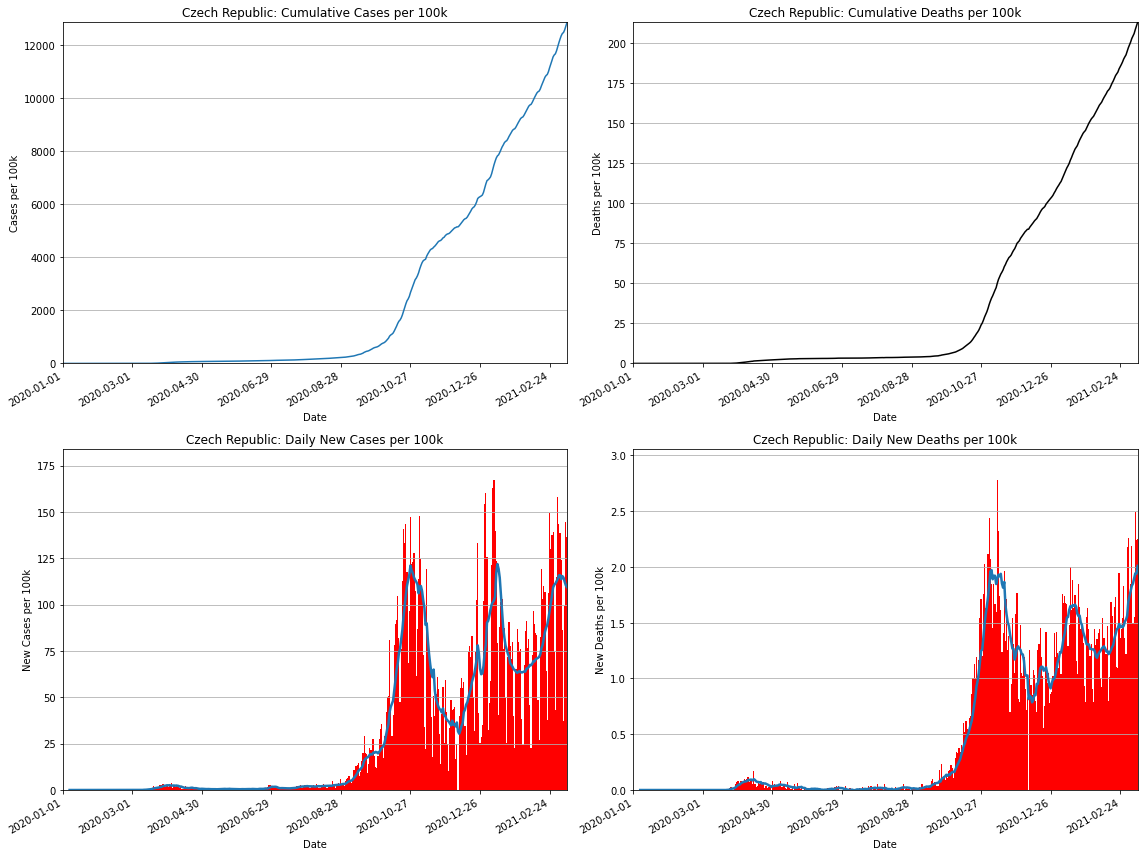

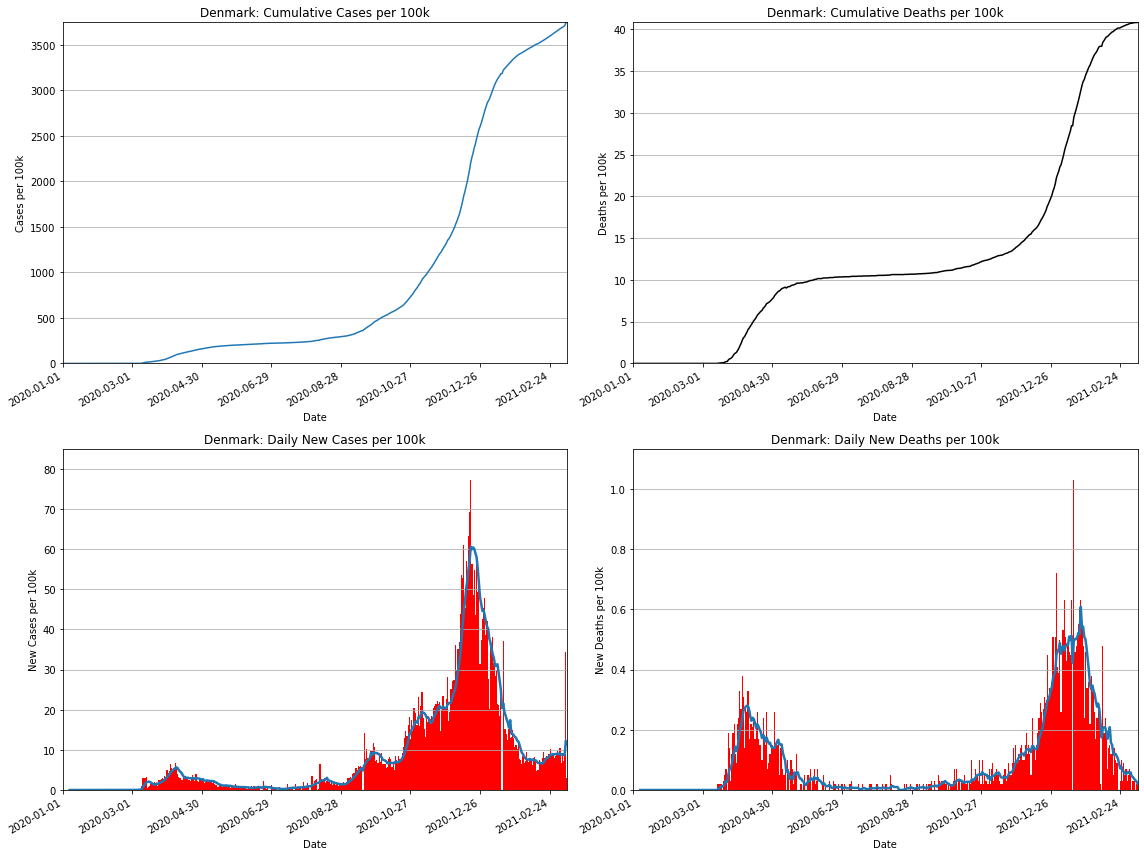

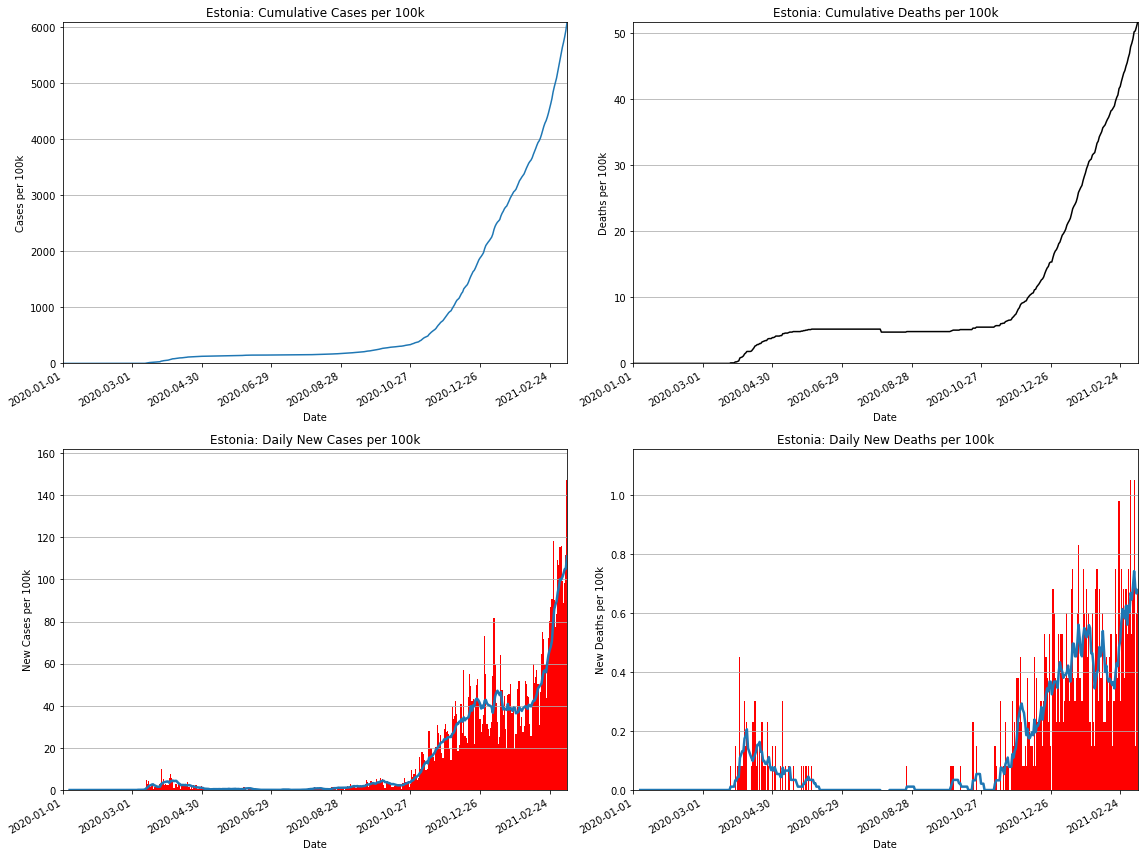

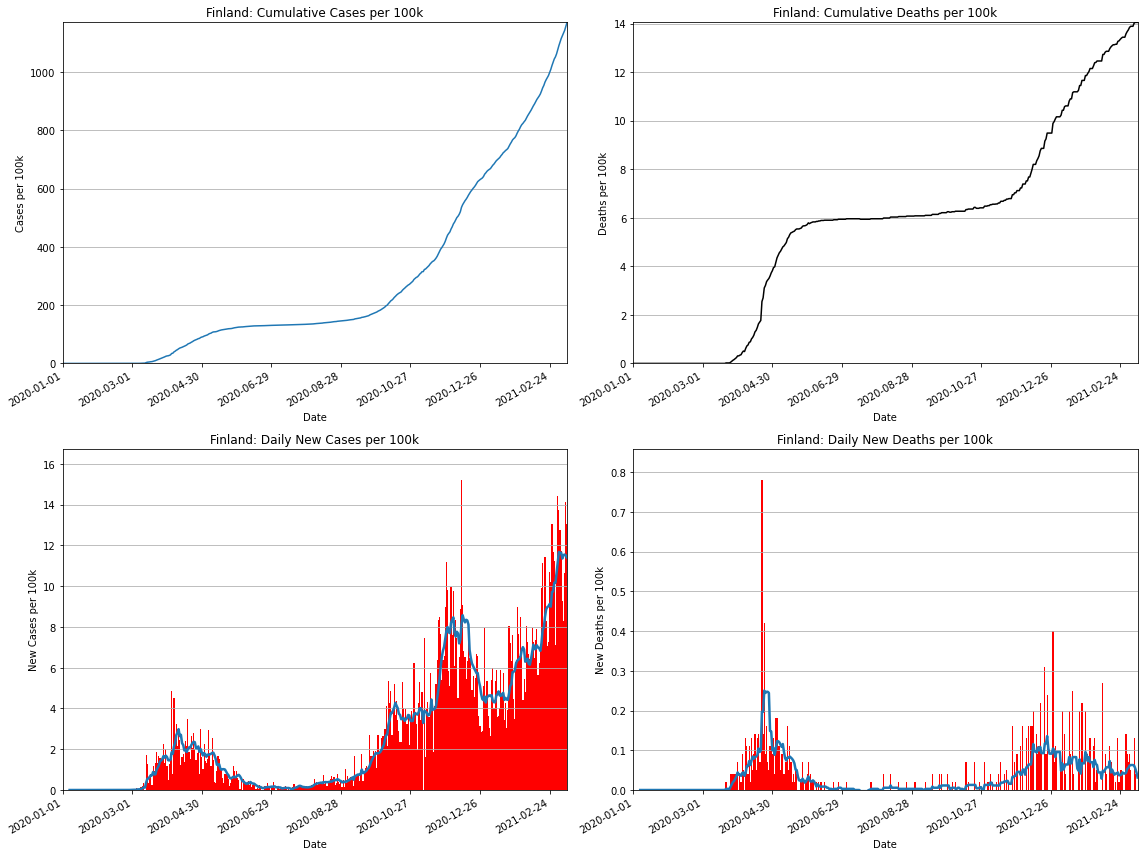

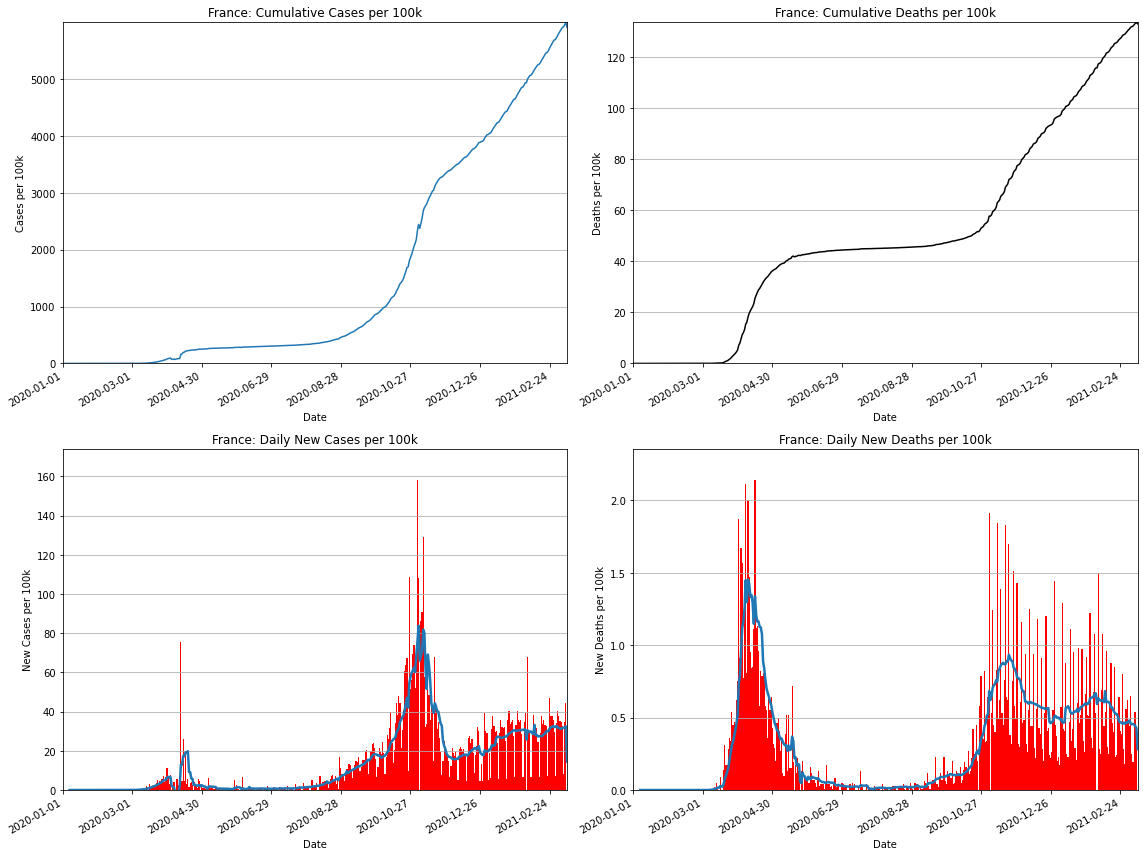

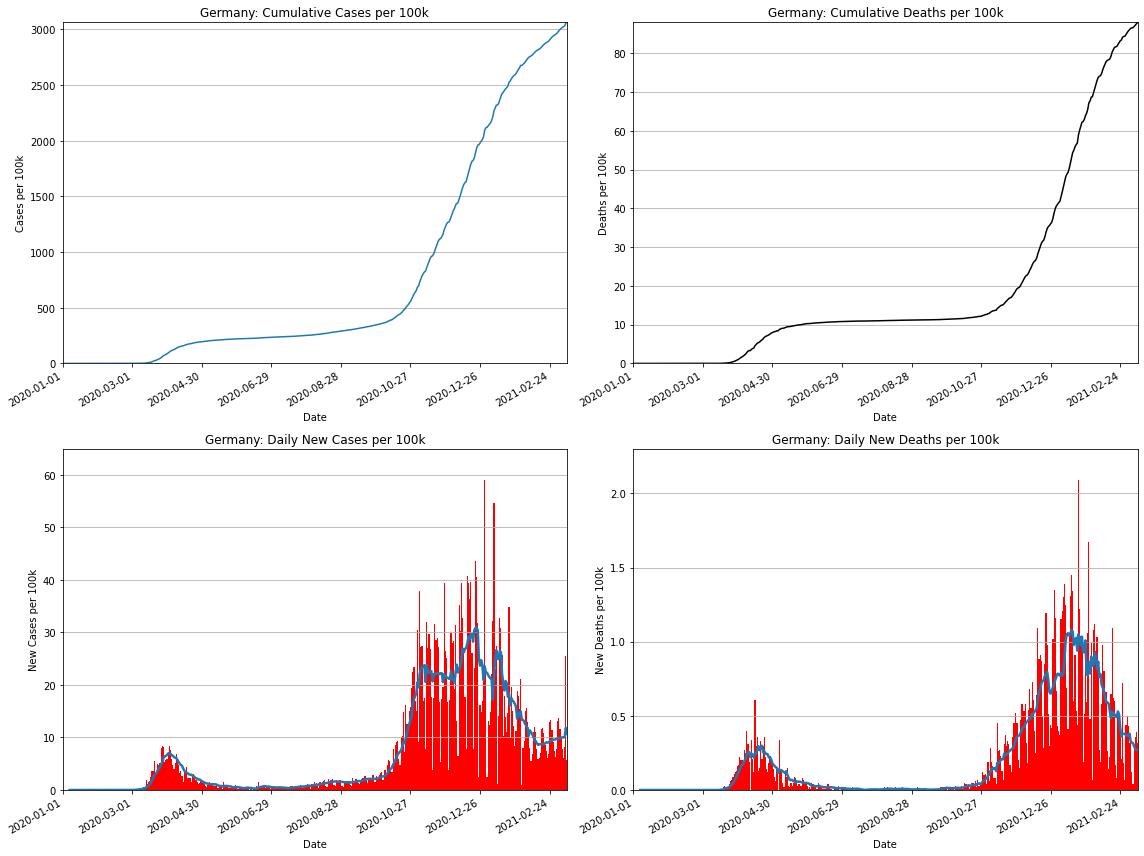

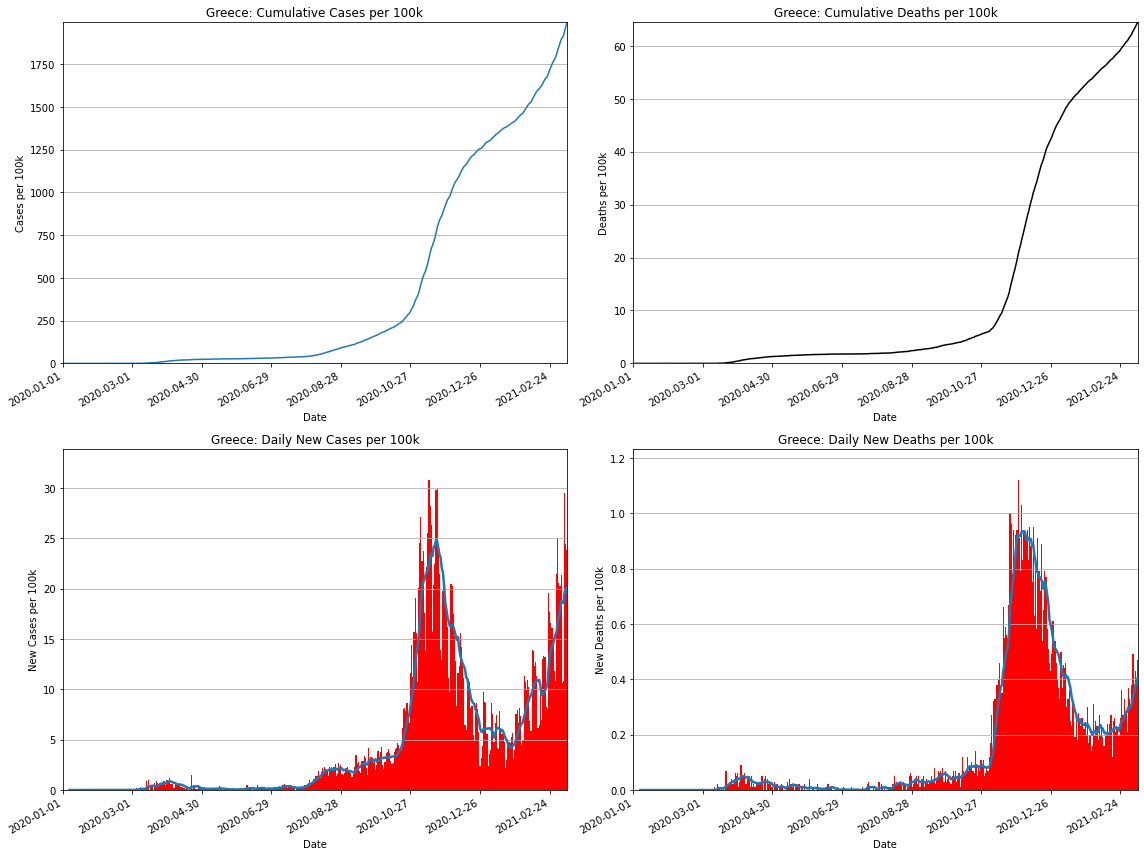

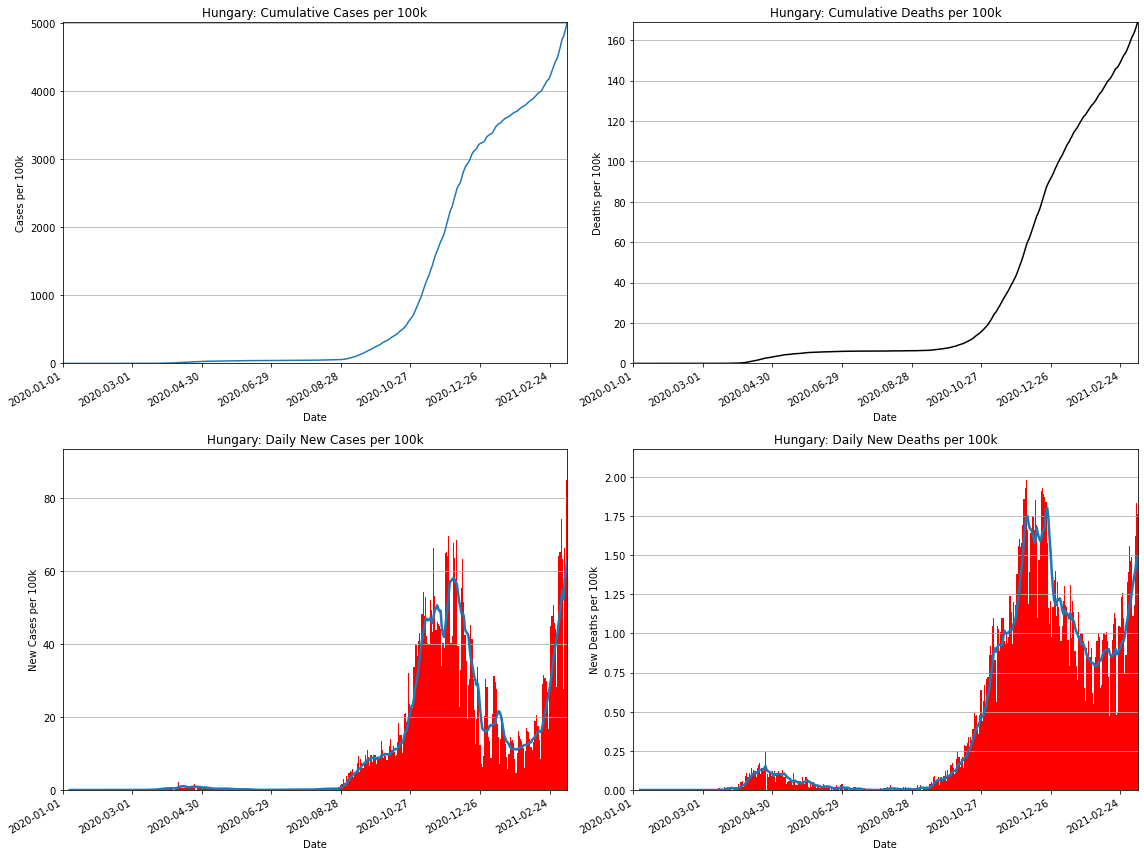

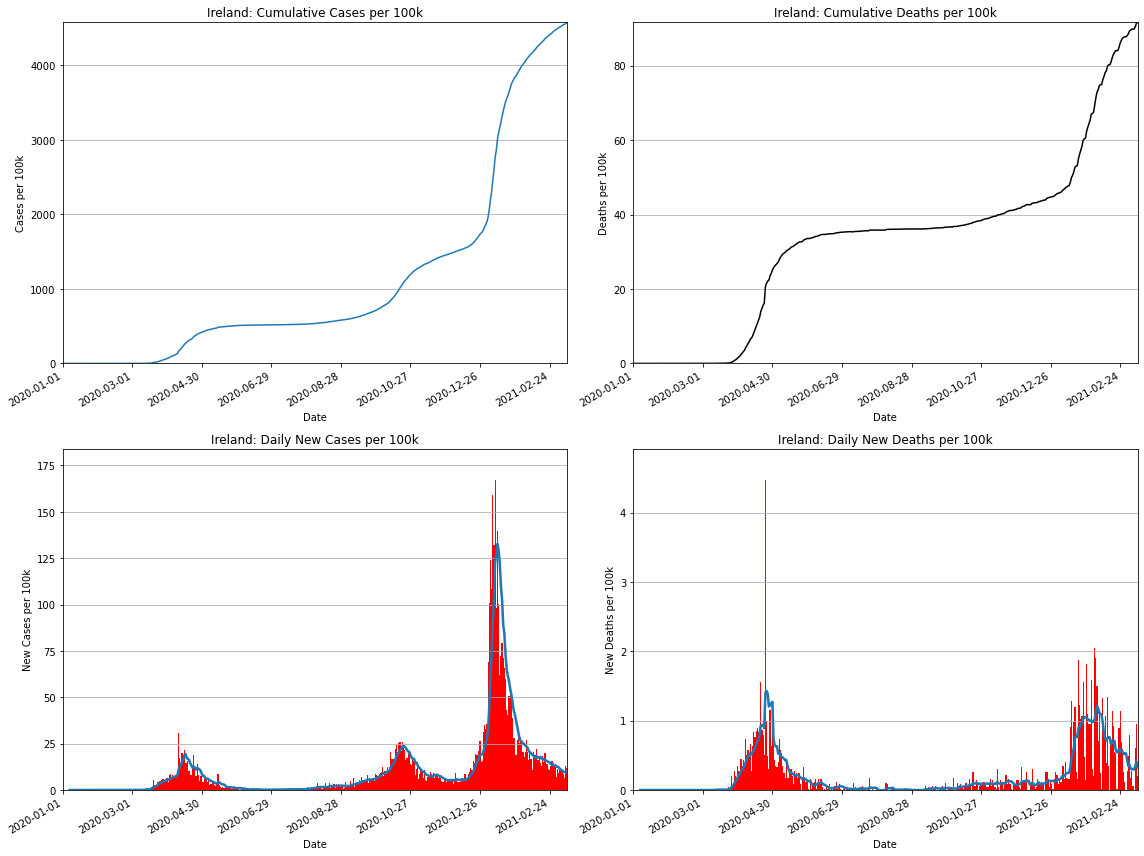

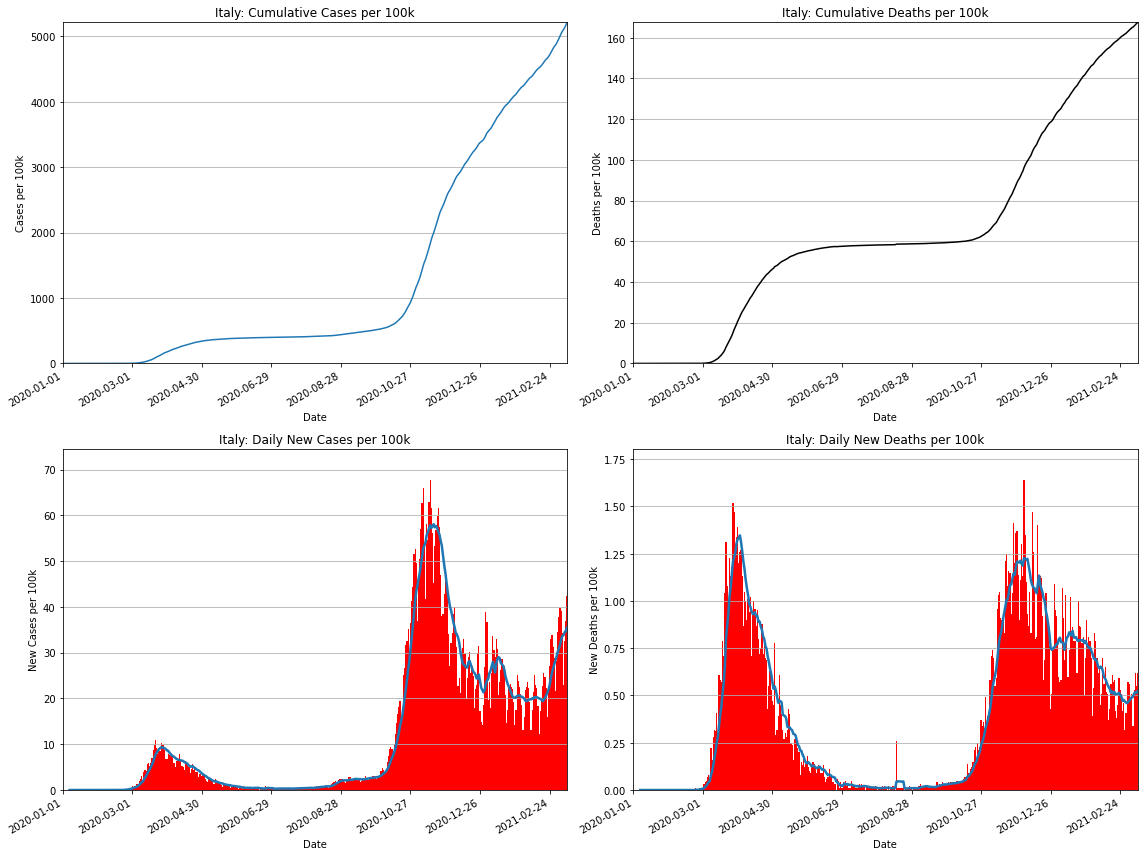

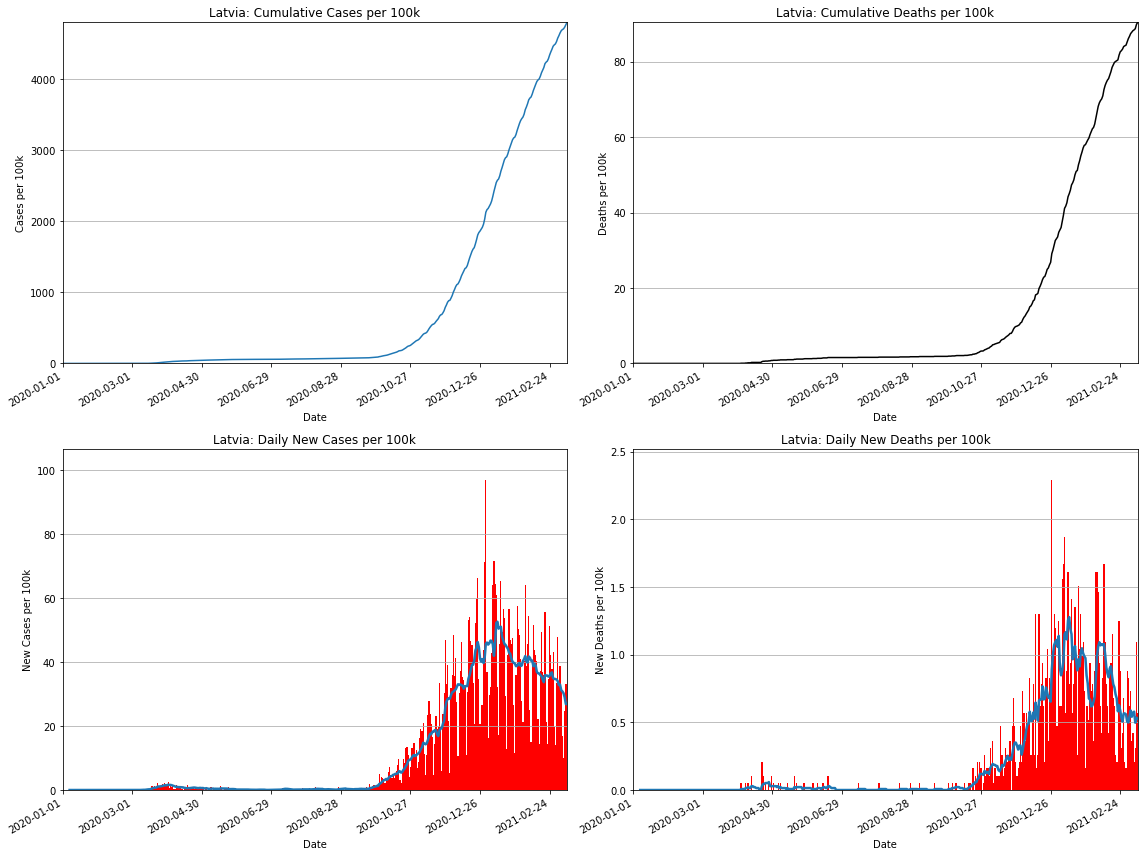

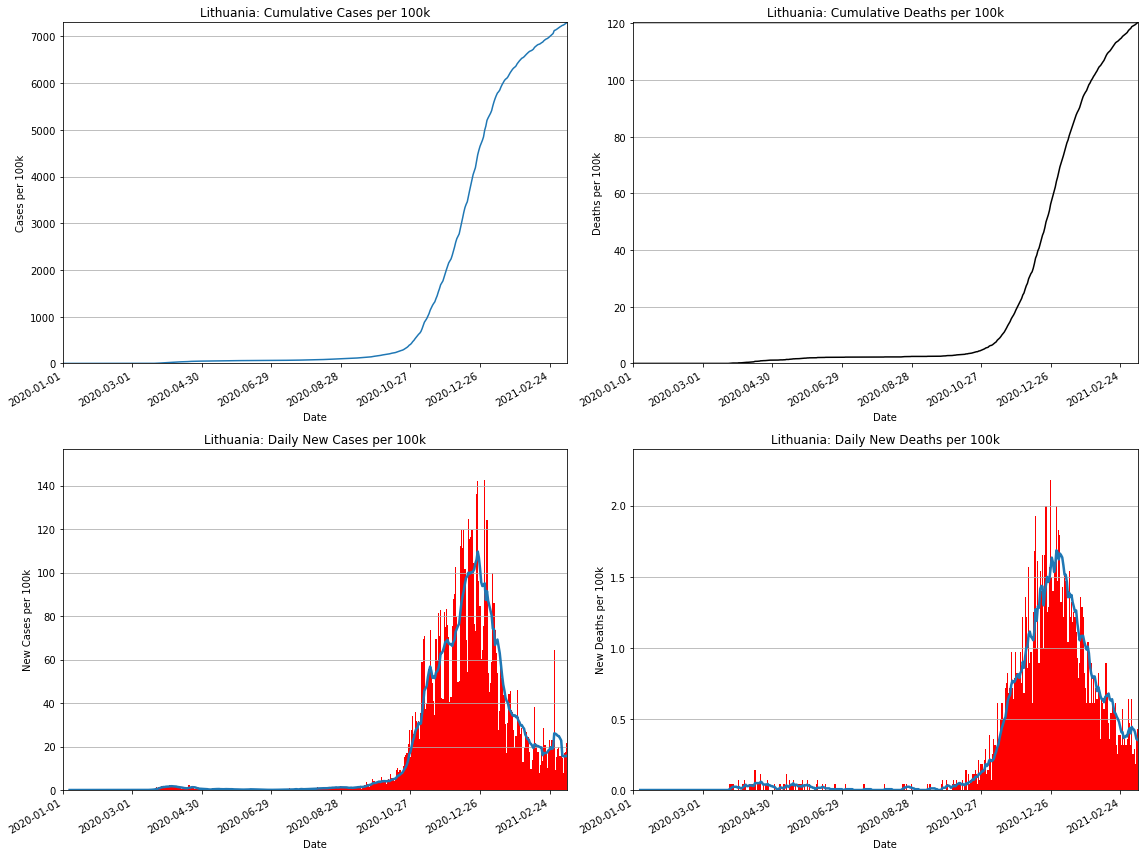

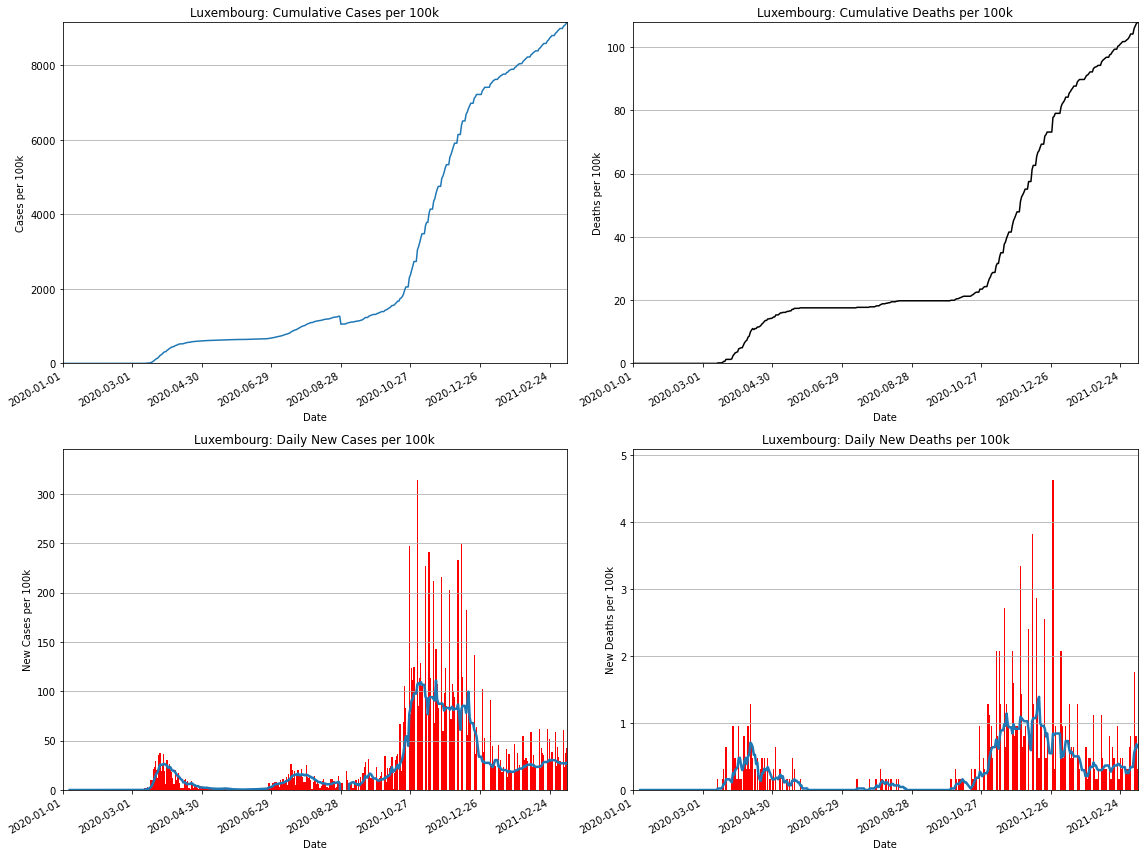

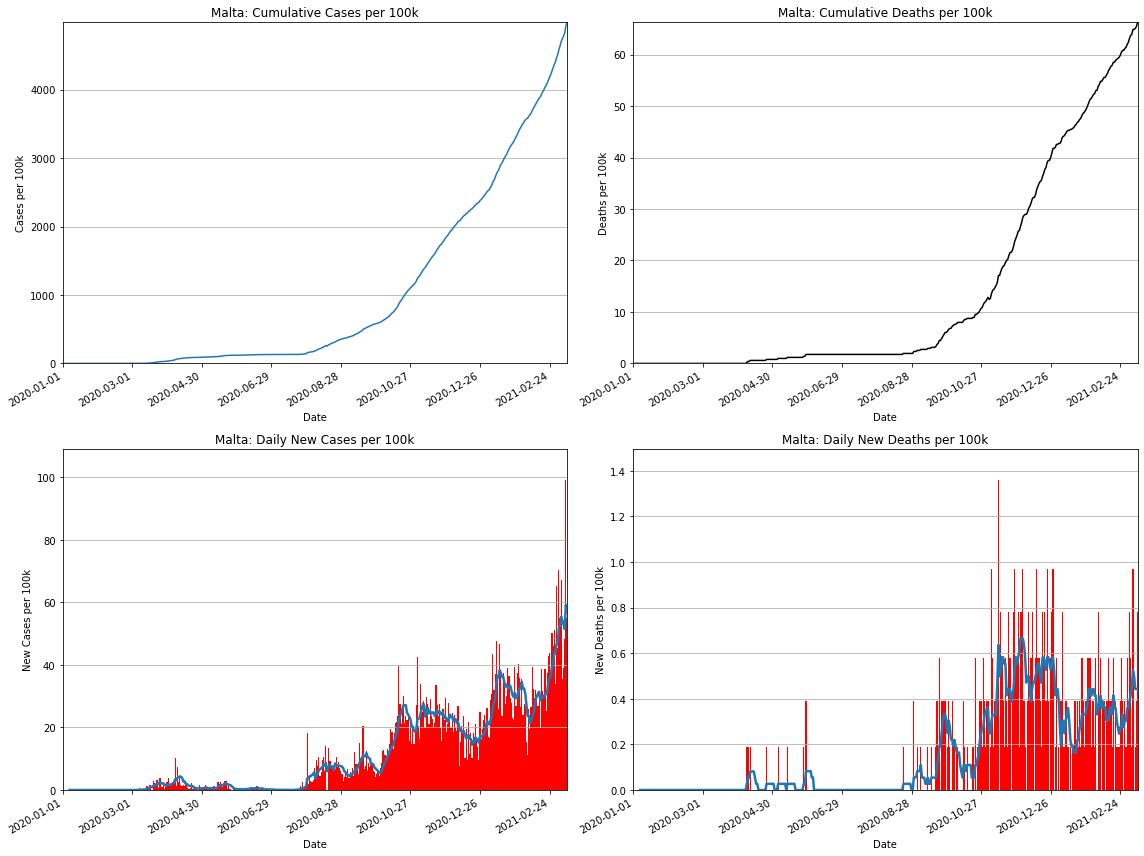

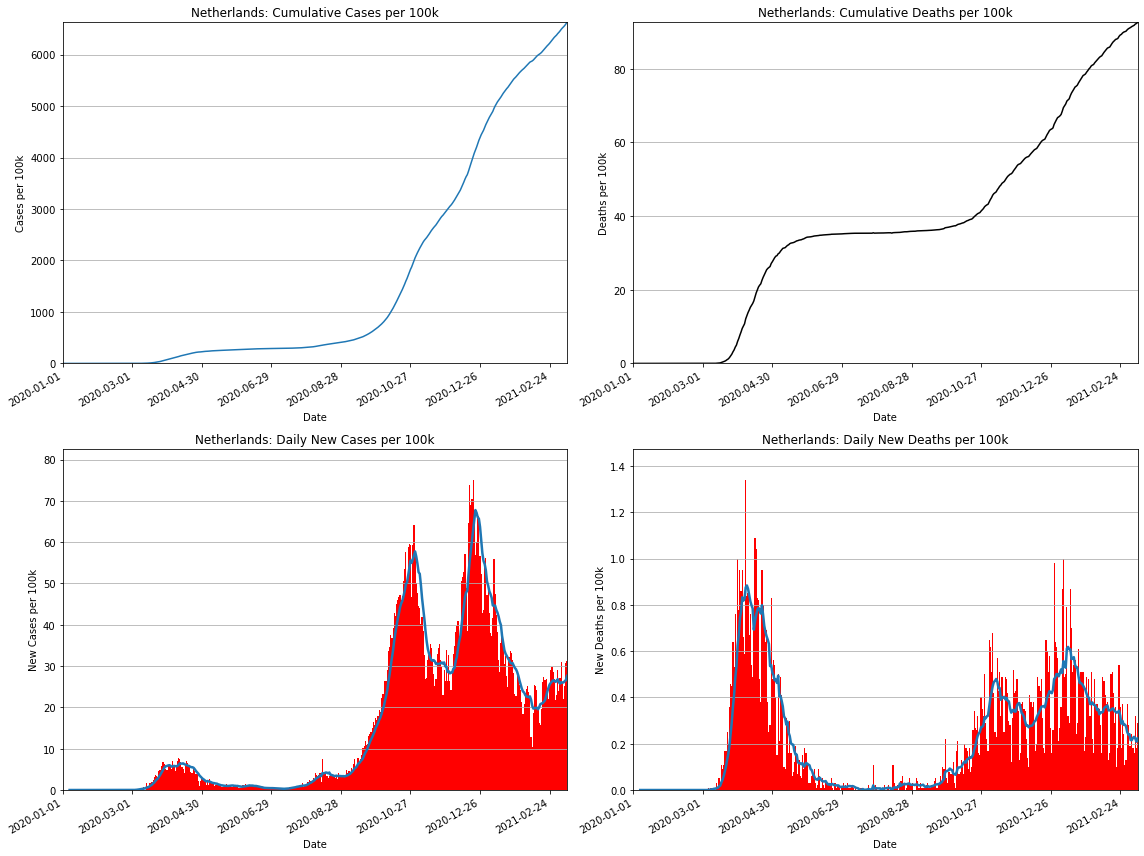

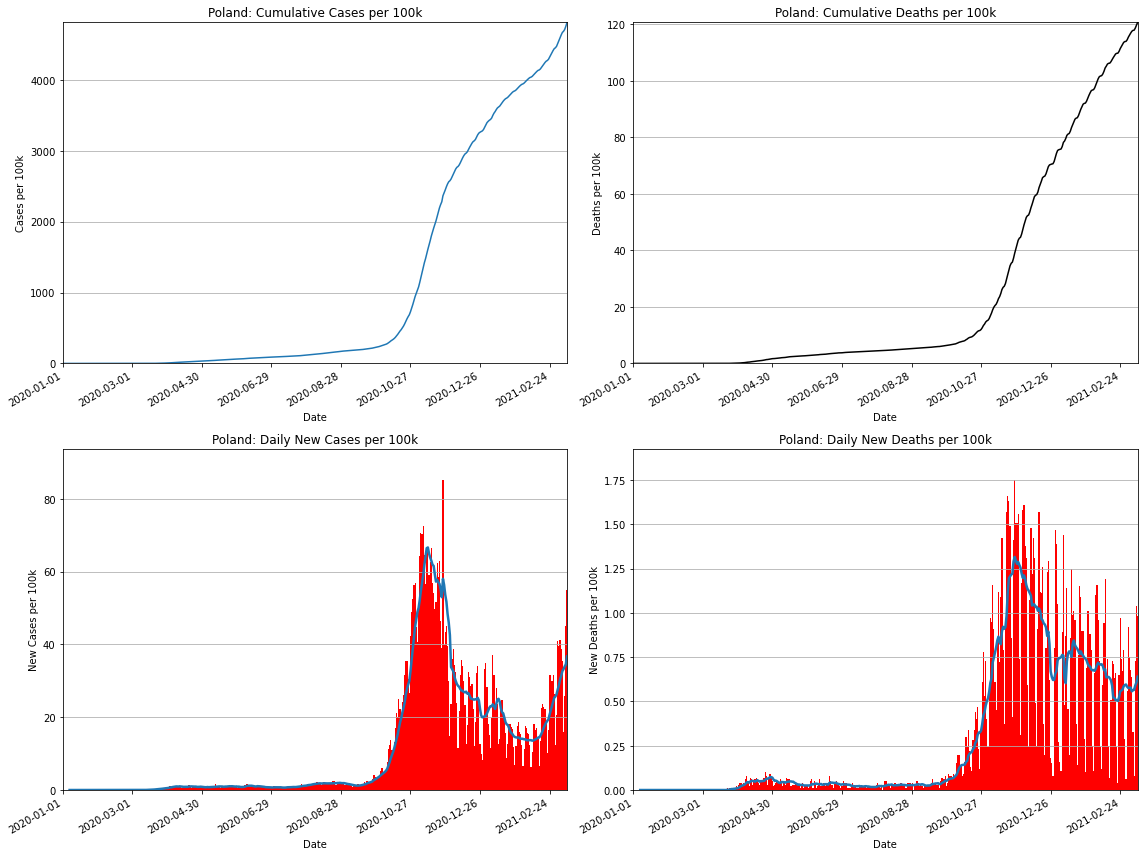

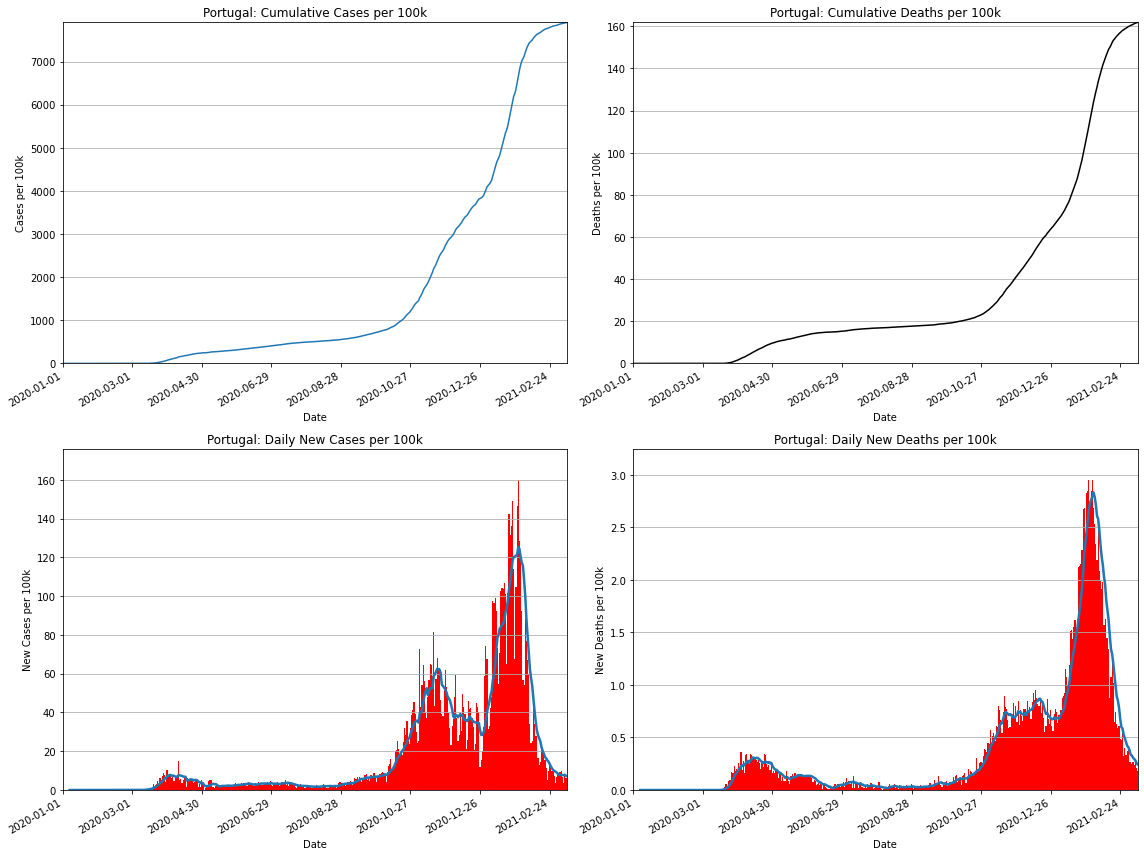

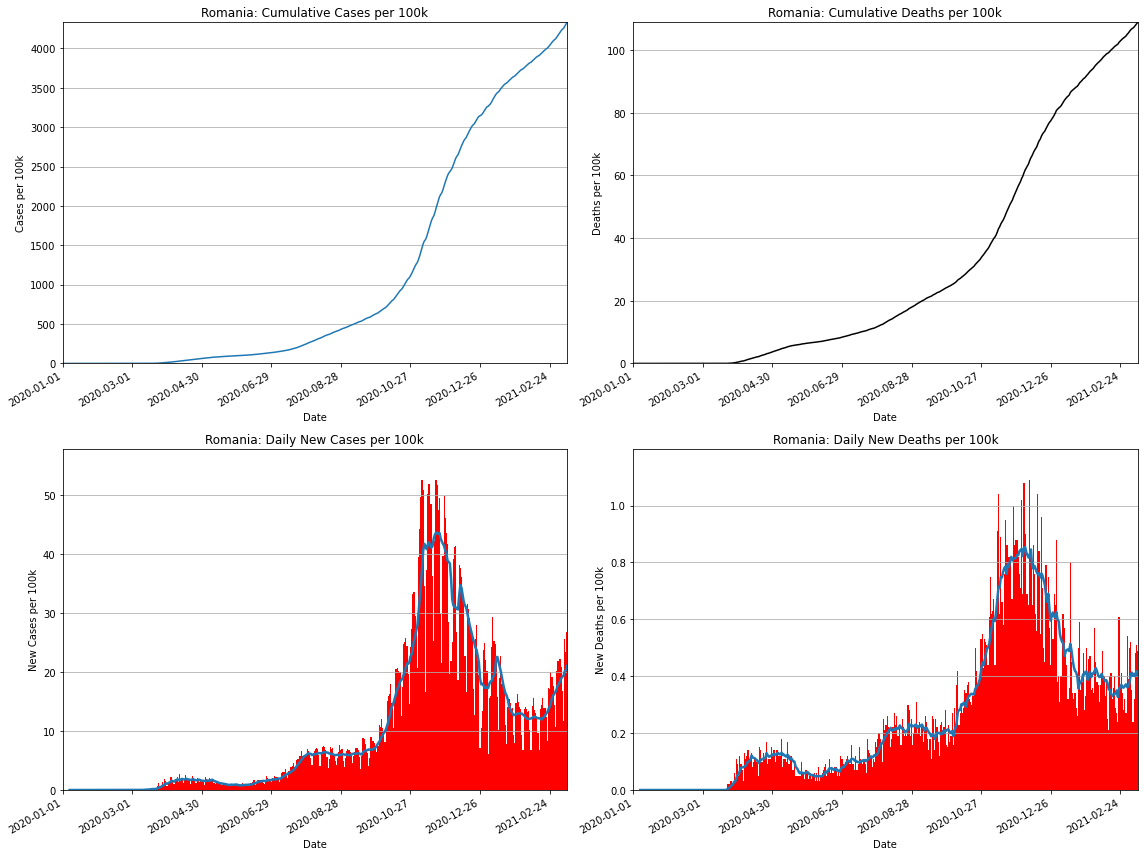

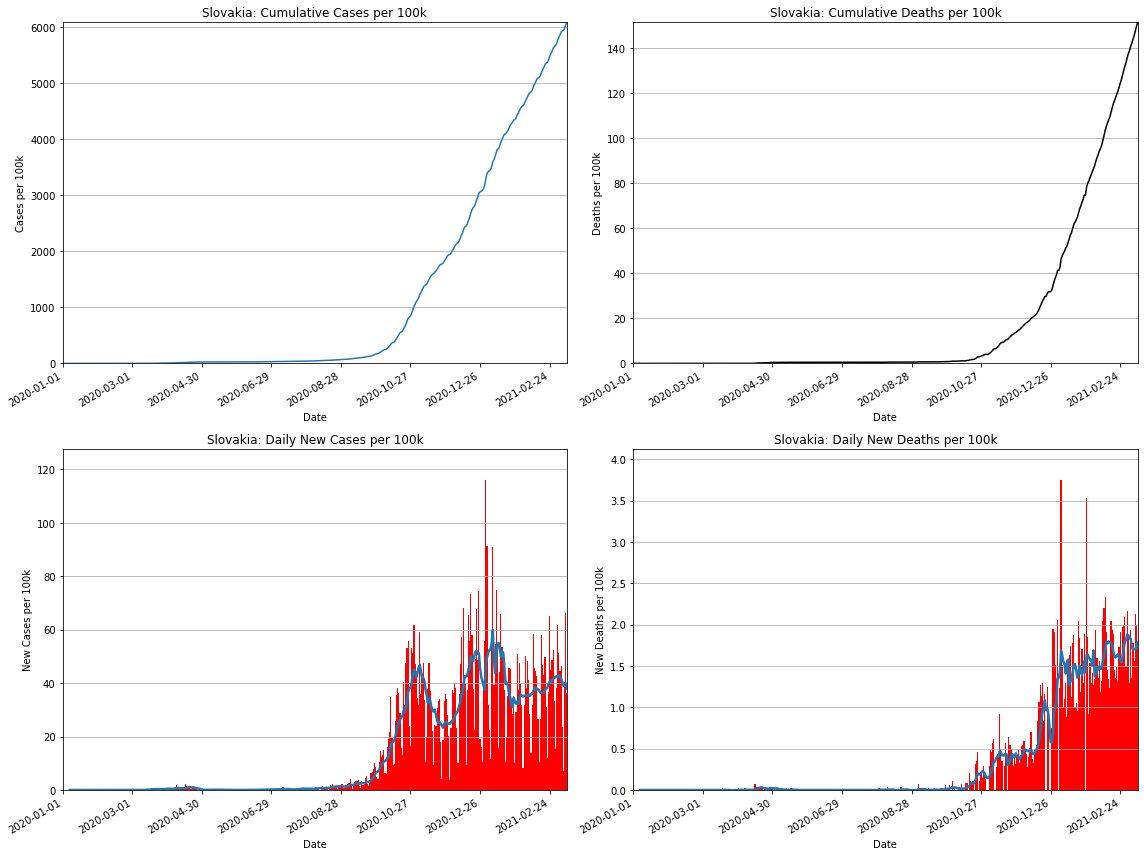

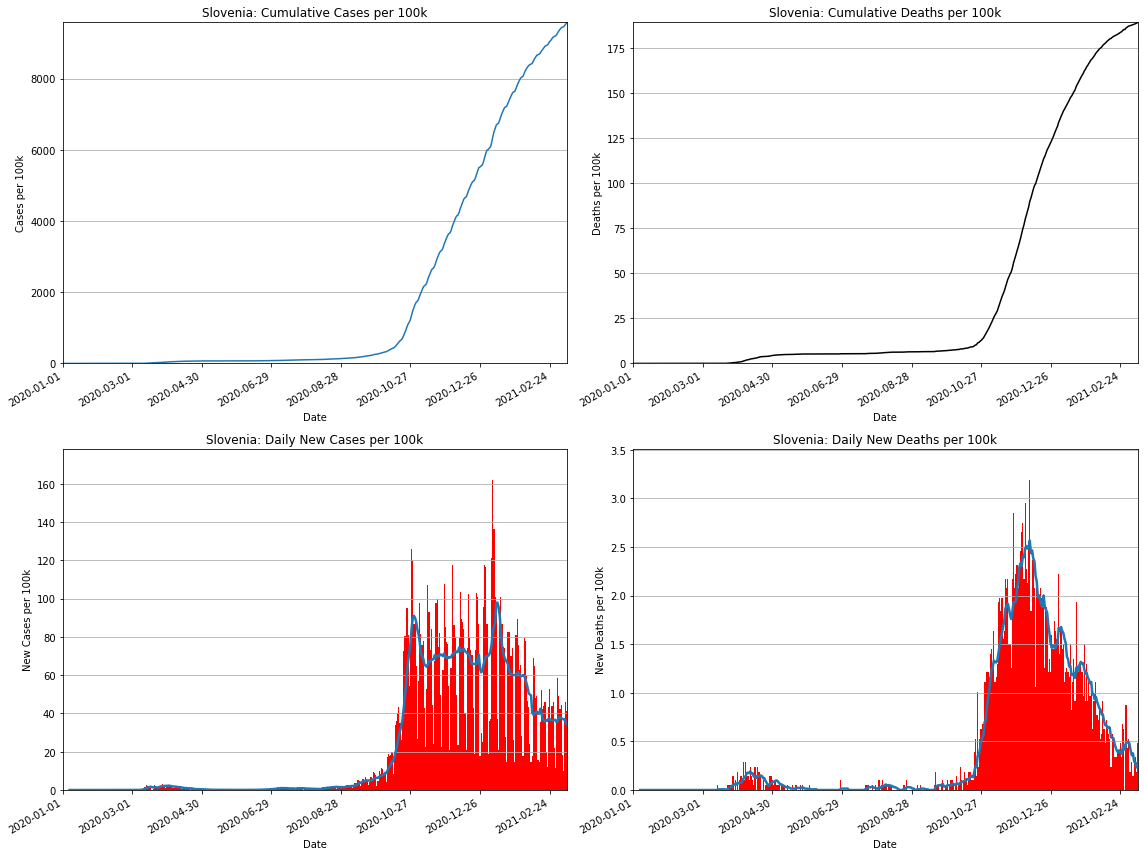

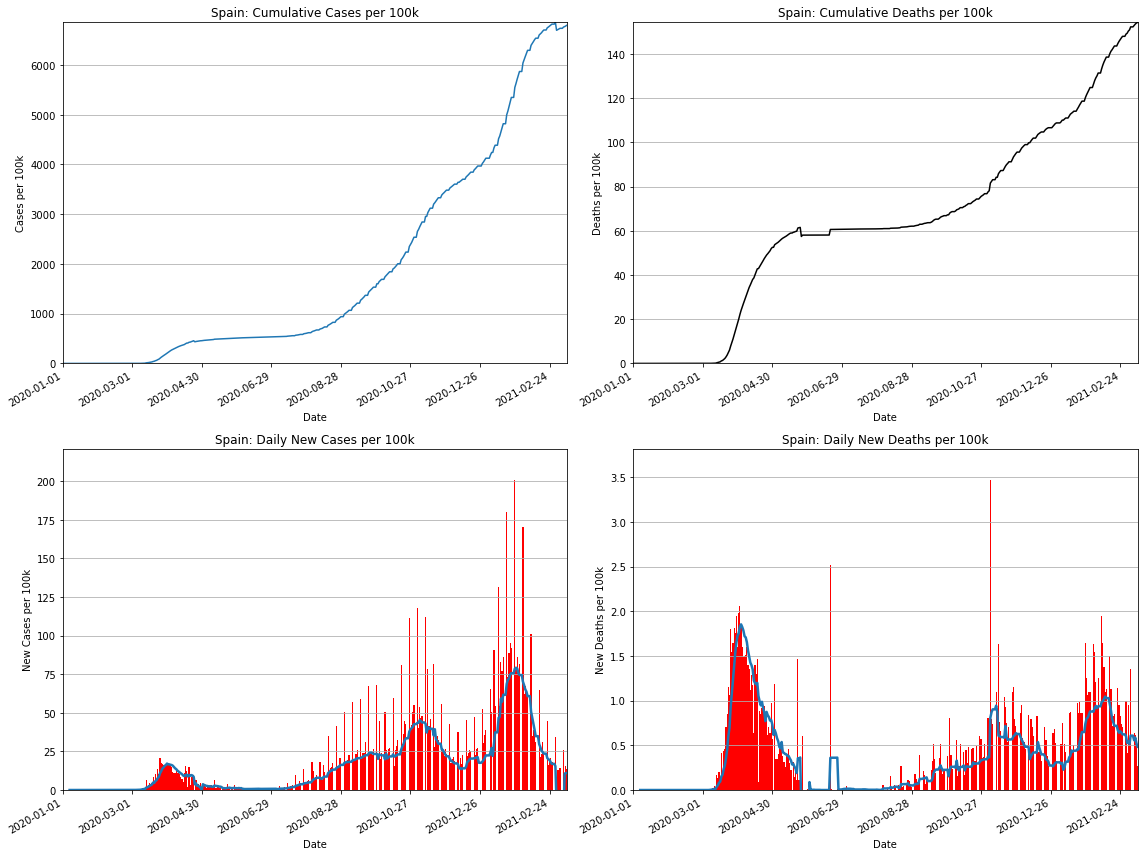

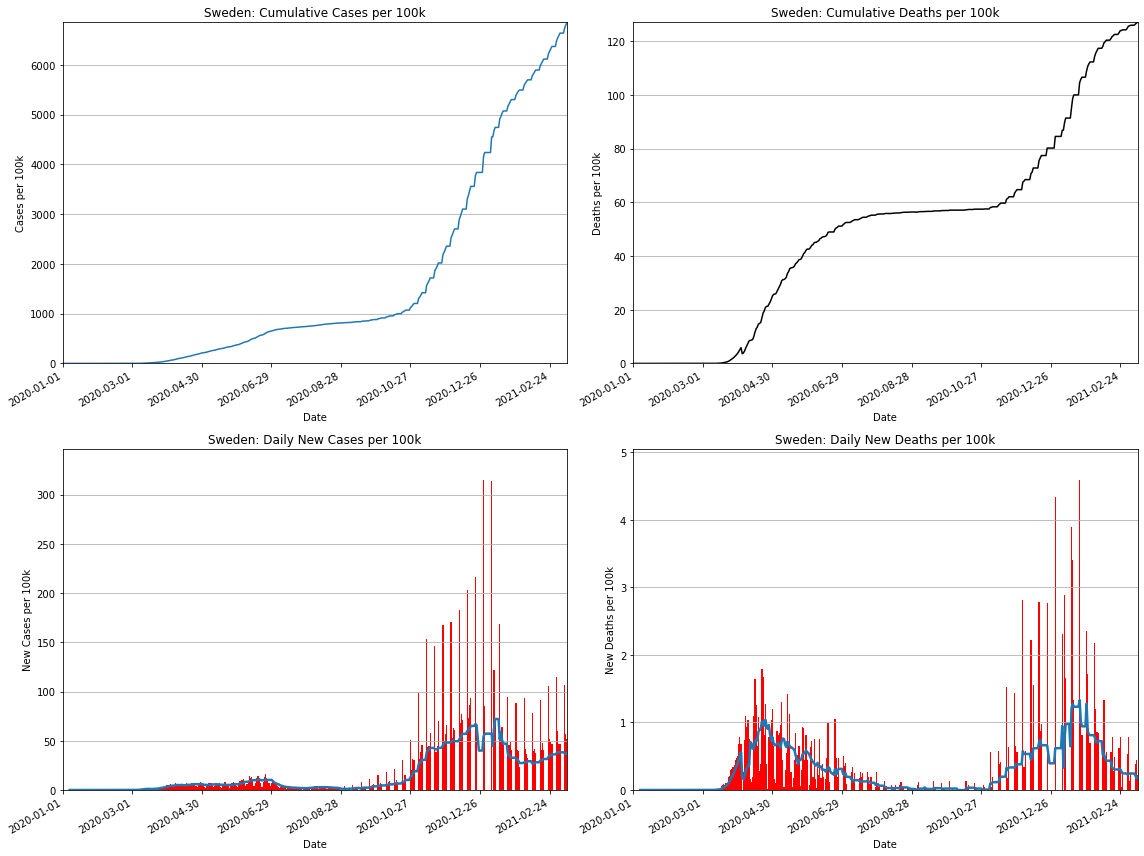

In [378]:
for c in countries:
    df=pd.read_csv(ProcessedDataFolder + f"/{c}_processed.csv")
    plotCovidDF(df)